## World Bank: Global Economic Indicators
#### Initial Thoughts
- Linear regression model to predict inflation rates and futue GDP
- Classficiation model to check if a country will fall under a certain category 
- Clustering to find groups of *similar* countries
- Time series to forecast growth or deprecation
### Conclusion at the end... 
- Actually very thourough analysis, ended up having quite a bit of fun

##### Used Libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from prophet import Prophet

c:\Users\mandy\OneDrive\Desktop\tea\tensorflow_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


#### Exploration & Insights

##### Load Dataset

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/global-economic-indicators-20102025/world_bank_data_2025.csv


In [3]:
df = pd.read_csv("/kaggle/input/global-economic-indicators-20102025/world_bank_data_2025.csv")
df.head(5)

NameError: name 'pd' is not defined

###### Lots of missing data...

In [4]:
missing = df.isnull().mean().sort_values(ascending=False) * 100
missing[missing > 0]

Public Debt (% of GDP)             75.460829
Interest Rate (Real, %)            50.028802
Government Expense (% of GDP)      47.580645
Government Revenue (% of GDP)      47.321429
Tax Revenue (% of GDP)             47.206221
Current Account Balance (% GDP)    26.180876
Inflation (CPI %)                  22.407834
Unemployment Rate (%)              19.498848
Gross National Income (USD)        19.470046
Inflation (GDP Deflator, %)        16.359447
GDP Growth (% Annual)              16.129032
GDP (Current USD)                  15.524194
GDP per Capita (Current USD)       15.380184
dtype: float64

###### There is a lot of columns with missing data, over 50%...

In [ ]:
 # clean up missing values by imputing median value
df_clean = df.drop(columns=missing[missing > 50].index)
for col in df_clean.select_dtypes(include="number").columns:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# remove extreme outliers for inflation and gdp columns
df_clean["Inflation (CPI %)"] = df_clean["Inflation (CPI %)"].clip(-10, 50)
df_clean["GDP Growth (% Annual)"] = df_clean["GDP Growth (% Annual)"].clip(-20, 20)

df_clean.describe()

,year,Inflation (CPI %),GDP (Current USD),GDP per Capita (Current USD),Unemployment Rate (%),"Inflation (GDP Deflator, %)",GDP Growth (% Annual),Current Account Balance (% GDP),Government Expense (% of GDP),Government Revenue (% of GDP),Tax Revenue (% of GDP),Gross National Income (USD)
count,3472.000000,3472.000000,3.472000e+03,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3.472000e+03
mean,2017.500000,5.556520,3.389061e+11,16690.807862,7.437487,6.076733,2.893366,-2.439890,26.695149,25.799161,16.663799,3.393889e+11
std,4.610436,17.421572,1.613358e+12,25463.708185,5.413687,23.646958,5.544714,11.806087,9.175981,13.179704,5.979539,1.622199e+12
min,2010.000000,-6.687321,3.210541e+07,193.007146,0.100000,-28.760135,-54.336155,-60.877754,0.000136,0.000081,0.000063,5.107533e+07
25%,2013.750000,1.880163,8.790270e+09,3041.026633,4.120000,1.595996,1.449744,-5.250706,25.416107,24.152743,15.845584,1.120315e+10
50%,2017.500000,3.213523,2.587360e+10,6827.668145,5.771000,3.223184,3.100442,-2.656009,26.000850,24.821425,16.321438,2.986520e+10
75%,2021.250000,5.088968,1.028211e+11,19079.136334,8.972250,6.000818,4.877890,-0.214290,26.785656,25.694412,16.781734,9.638831e+10
max,2025.000000,557.201817,2.772071e+13,256580.515123,35.359000,921.535652,86.826748,235.750605,103.725787,344.999451,147.640196,2.757614e+13


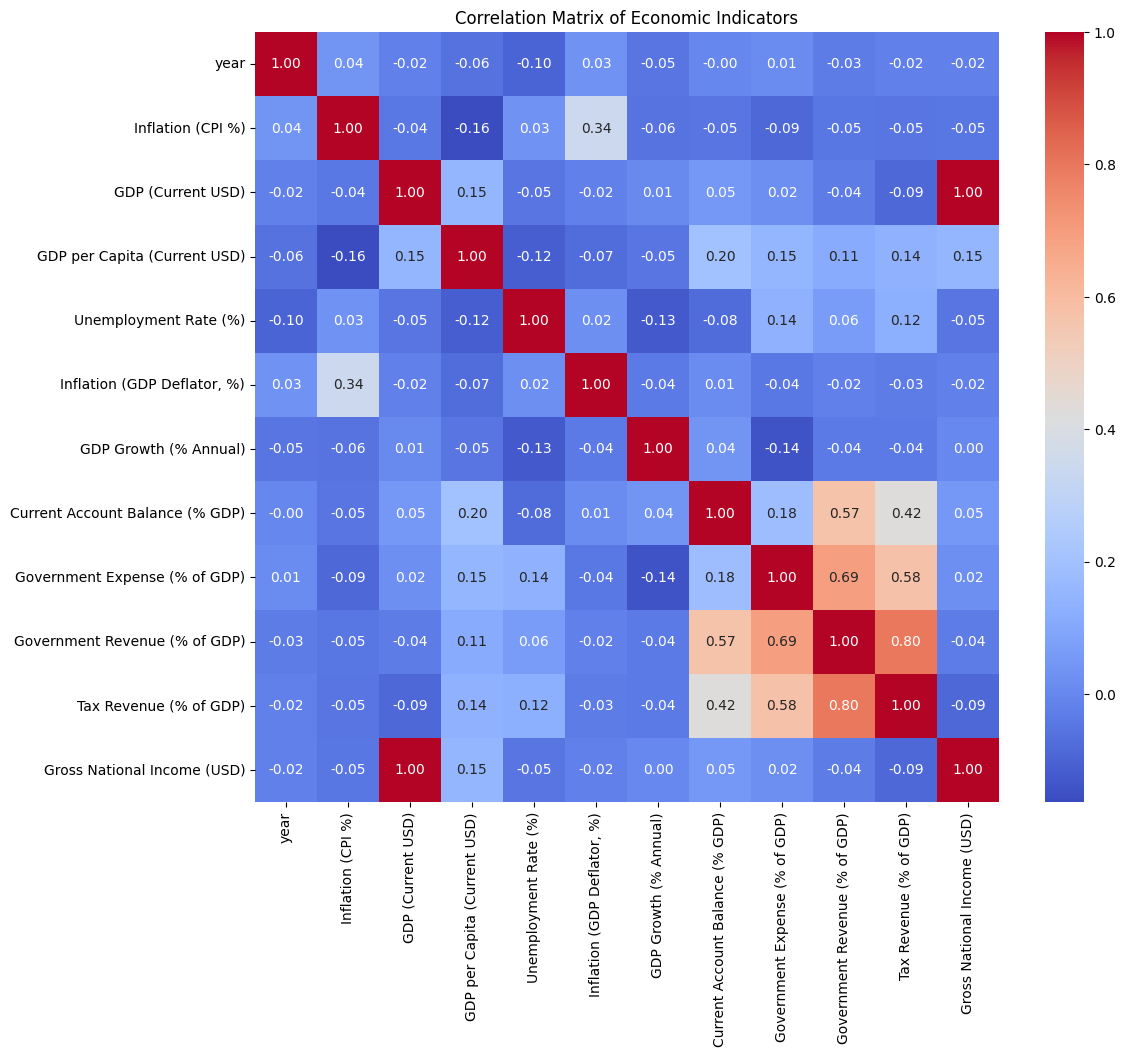

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Economic Indicators")
plt.show()

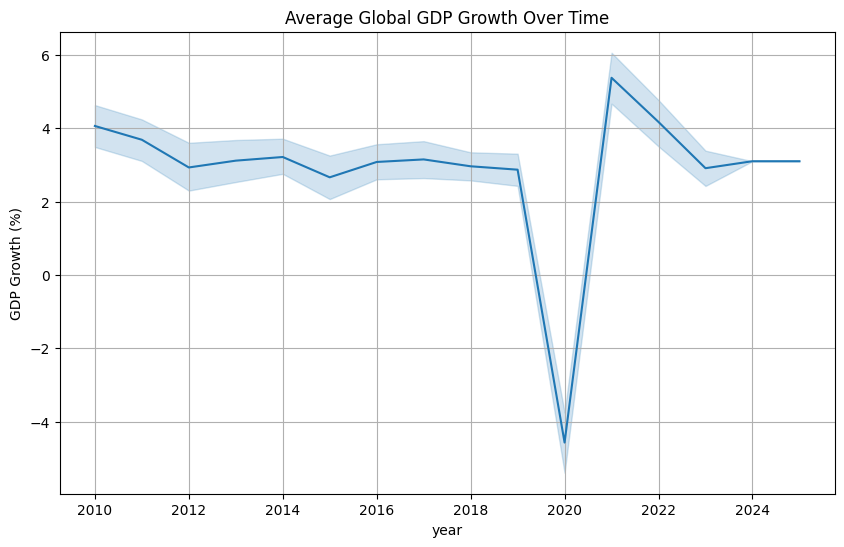

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_clean, x='year', y='GDP Growth (% Annual)', estimator='mean')
plt.title("Average Global GDP Growth Over Time")
plt.ylabel("GDP Growth (%)")
plt.grid(True)
plt.show()

###### Covid...

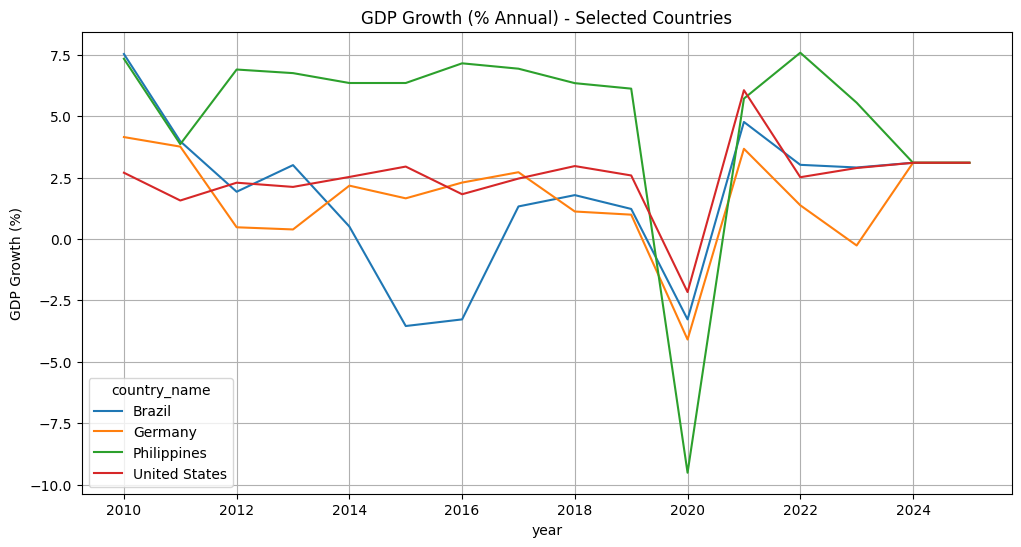

In [18]:
countries = ['Philippines', 'Germany', 'United States', 'Brazil']
df_subset = df_clean[df_clean['country_name'].isin(countries)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_subset, x='year', y='GDP Growth (% Annual)', hue='country_name')
plt.title("GDP Growth (% Annual) - Selected Countries")
plt.ylabel("GDP Growth (%)")
plt.grid(True)
plt.show()

###### Covid hit the Philippines especially hard :(

#### Regression Model, Predict GDP Growth

In [25]:
df_model = df_clean.drop(columns=['country_name', 'country_id'])

# Drop rows with missing target
df_model = df_model.dropna(subset=['GDP Growth (% Annual)'])

# Features (X) and Target (y)
X = df_model.drop(columns=['GDP Growth (% Annual)', 'year'])
y = df_model['GDP Growth (% Annual)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict
y_pred = reg.predict(X_test)

# Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: 0.0233264982664243
RMSE: 4.250377274732072


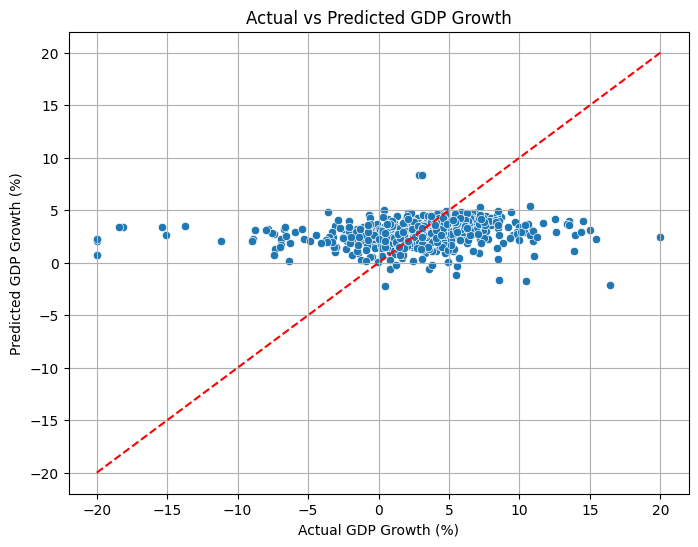

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([-20, 20], [-20, 20], 'r--')
plt.xlabel("Actual GDP Growth (%)")
plt.ylabel("Predicted GDP Growth (%)")
plt.title("Actual vs Predicted GDP Growth")
plt.grid(True)
plt.show()

###### Lowkey horrible

#### Classification Model, High vs. Low Inflation

In [26]:
# Binary target: High Inflation
df_class = df_clean.copy()
df_class = df_class.dropna(subset=['Inflation (CPI %)'])
df_class['High_Inflation'] = (df_class['Inflation (CPI %)'] > 10).astype(int)

# Features and target
Xc = df_class.drop(columns=['country_name', 'country_id', 'year', 'Inflation (CPI %)', 'High_Inflation'])
yc = df_class['High_Inflation']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

# Evaluation
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print("Classification Report:\n", classification_report(yc_test, yc_pred))

Accuracy: 0.9453237410071943
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       639
           1       0.74      0.50      0.60        56

    accuracy                           0.95       695
   macro avg       0.85      0.74      0.78       695
weighted avg       0.94      0.95      0.94       695



###### Not too bad

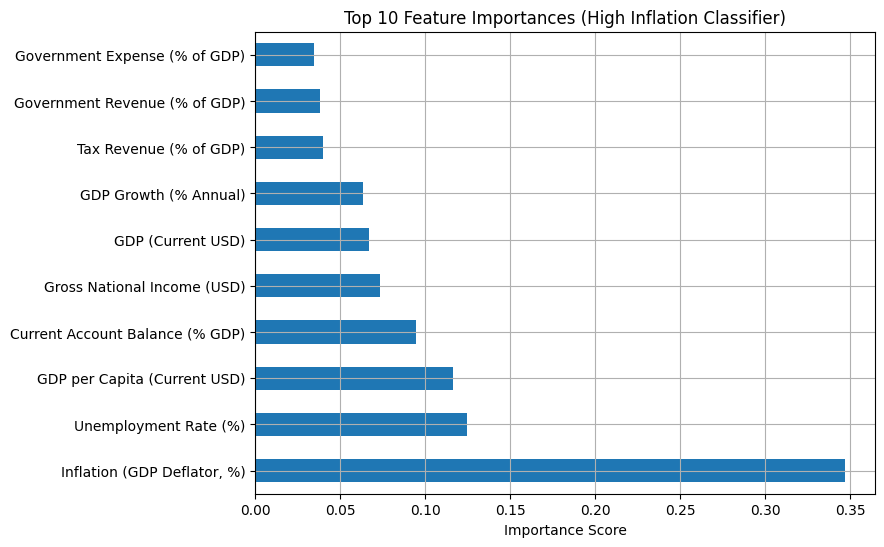

In [27]:
feat_importances = pd.Series(clf.feature_importances_, index=Xc.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(8, 6))
plt.title("Top 10 Feature Importances (High Inflation Classifier)")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()

###### Not surprised inflation most important classifier

#### Unsupervised Learning, Clustering Countries

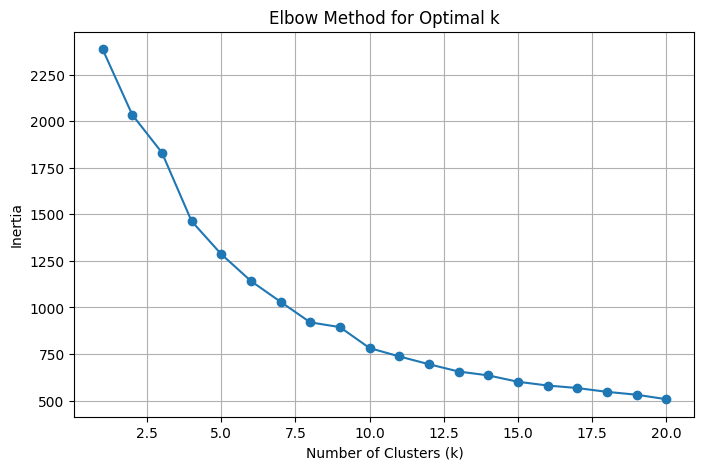

In [30]:
# Prepare dataset: average values per country
df_cluster = df_clean.groupby('country_name').mean(numeric_only=True)

# Drop non-informative or ID columns
df_cluster = df_cluster.drop(columns=['year'])

# Handle missing values (fill with median)
df_cluster.fillna(df_cluster.median(), inplace=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Elbow method
inertia = []
K_range = range(1, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [46]:
# Choose number of clusters (adjust based on elbow curve)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_cluster = df.groupby("country_name").mean(numeric_only=True).drop(columns=["year"])
df_cluster_filled = df_cluster.fillna(df_cluster.median(numeric_only=True))

# Assign cluster labels back to country names
df_cluster['Cluster'] = clusters
df_cluster.head()

,Inflation (CPI %),GDP (Current USD),GDP per Capita (Current USD),Unemployment Rate (%),"Interest Rate (Real, %)","Inflation (GDP Deflator, %)",GDP Growth (% Annual),Current Account Balance (% GDP),Government Expense (% of GDP),Government Revenue (% of GDP),Tax Revenue (% of GDP),Gross National Income (USD),Public Debt (% of GDP),Cluster
country_name,,,,,,,,,,,,,,
Afghanistan,3.820777,1.807256e+10,523.013475,10.471867,10.426353,4.751130,1.479044,-17.862624,44.940683,10.833808,8.348214,1.818867e+10,NaN,2
Albania,2.576380,1.472944e+10,5172.163337,13.234667,5.478972,2.460824,2.877387,-8.286192,24.155552,24.358525,17.871101,1.466802e+10,74.319358,2
Algeria,5.251194,2.044591e+11,4991.221498,11.458800,2.372314,6.121009,2.450000,-3.095225,NaN,NaN,NaN,2.014052e+11,NaN,2
American Samoa,NaN,6.652308e+08,12843.035014,NaN,NaN,2.527986,-0.210915,NaN,NaN,NaN,NaN,NaN,NaN,2
Andorra,NaN,3.226747e+09,42163.795077,NaN,NaN,1.417652,0.738900,14.884694,NaN,NaN,NaN,3.505753e+09,NaN,2


,PCA Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.273446,0.273446
1,PC2,0.195754,0.469200


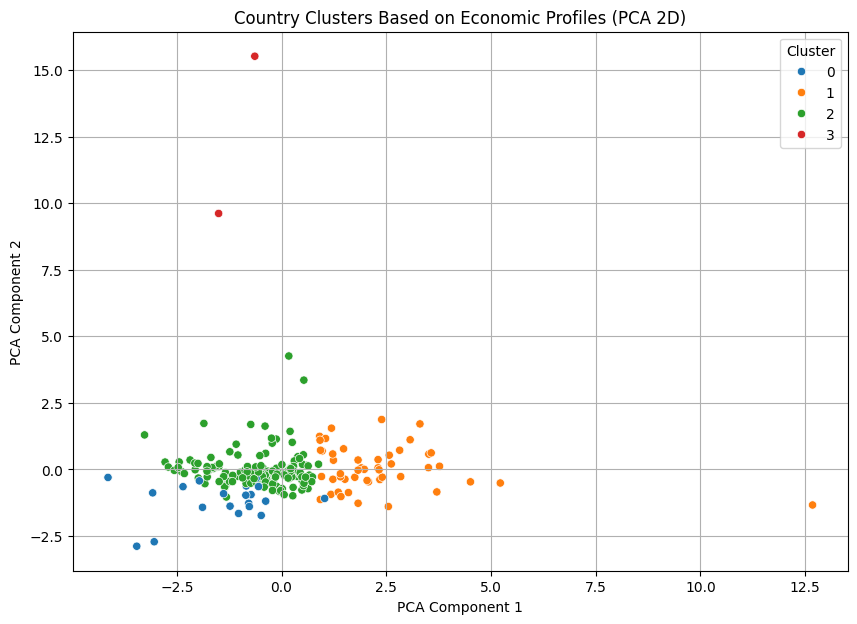

In [47]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

explained_variance = pd.DataFrame({
    'PCA Component': [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': pca.explained_variance_ratio_.cumsum()
})
display(explained_variance)


plt.figure(figsize=(10, 7))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=clusters, palette='tab10')
plt.title("Country Clusters Based on Economic Profiles (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

###### Doesn't actually seem to be that separable, but then again the explained variance is very low

,Inflation (CPI %),GDP (Current USD),GDP per Capita (Current USD),Unemployment Rate (%),"Interest Rate (Real, %)","Inflation (GDP Deflator, %)",GDP Growth (% Annual),Current Account Balance (% GDP),Government Expense (% of GDP),Government Revenue (% of GDP),Tax Revenue (% of GDP),Gross National Income (USD),Public Debt (% of GDP)
Cluster,,,,,,,,,,,,,
0,30.310922,1.588270e+11,3795.945730,8.570549,-0.478887,30.545064,1.879499,-4.602906,23.480728,21.787006,14.076768,1.559701e+11,45.885716
1,2.802041,3.539655e+11,41345.166775,8.949964,3.611107,3.062893,2.363192,4.607647,38.665844,38.816693,23.010949,3.509653e+11,60.113164
2,3.920129,2.106098e+11,12534.526612,7.084978,6.082685,4.644922,3.032164,-4.220348,22.837323,22.006467,14.689133,2.106695e+11,50.751942
3,2.348037,1.615161e+13,35161.647141,5.209067,2.038788,2.500344,4.604376,-0.361293,25.036408,16.179061,9.814506,1.622209e+13,75.345228


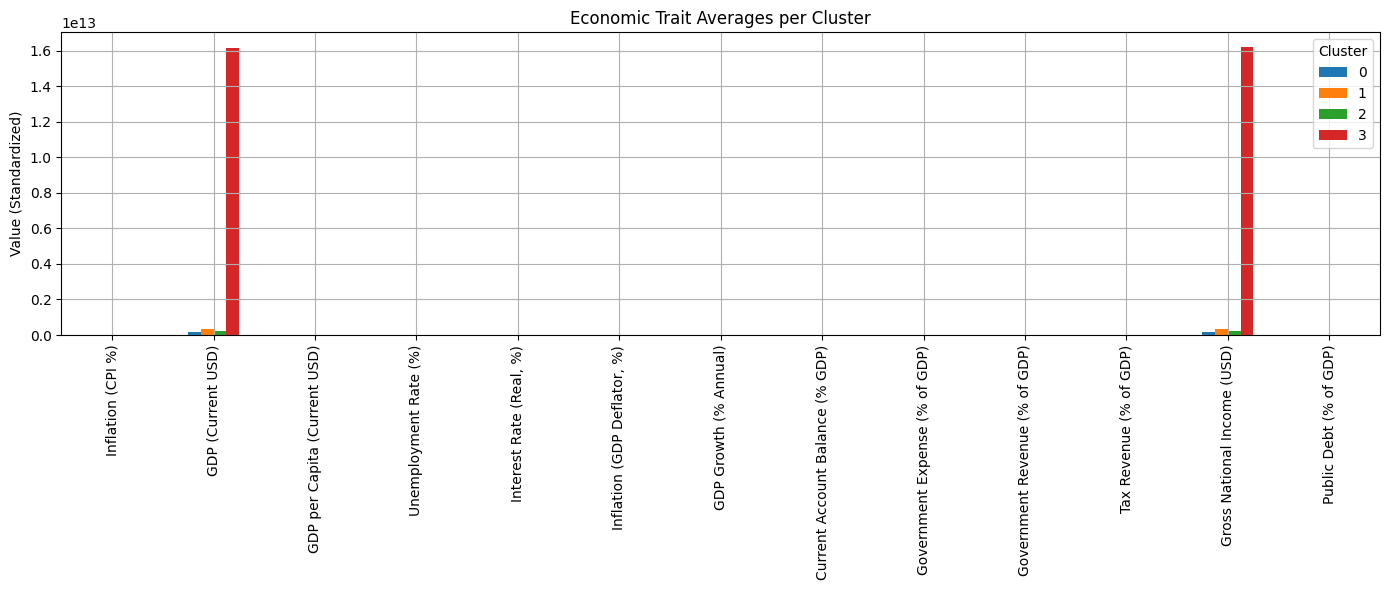

In [48]:
df_cluster_filled['Cluster'] = clusters

# Average economic traits by cluster
cluster_traits = df_cluster_filled.groupby('Cluster').mean()
display(cluster_traits)

# Optional: visualize traits per cluster
cluster_traits.T.plot(kind='bar', figsize=(14, 6))
plt.title("Economic Trait Averages per Cluster")
plt.ylabel("Value (Standardized)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Time series to forecast feature

###### Let's explore the Philippines :D, #1 country in corruption yay 

In [49]:
# Choose a country
country = 'Philippines'

# Extract yearly GDP growth for that country
df_ts = df[df['country_name'] == country][['year', 'GDP Growth (% Annual)']].dropna()

# Rename columns for Prophet
df_ts = df_ts.rename(columns={'year': 'ds', 'GDP Growth (% Annual)': 'y'})

# Convert year to datetime
df_ts['ds'] = pd.to_datetime(df_ts['ds'], format='%Y')

df_ts.head()

,ds,y
2448,2010-01-01,7.334500
2449,2011-01-01,3.858233
2450,2012-01-01,6.896952
2451,2013-01-01,6.750531
2452,2014-01-01,6.347987


11:54:28 - cmdstanpy - INFO - Chain [1] start processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mandy\OneDrive\Desktop\tea\tensorflow_env\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


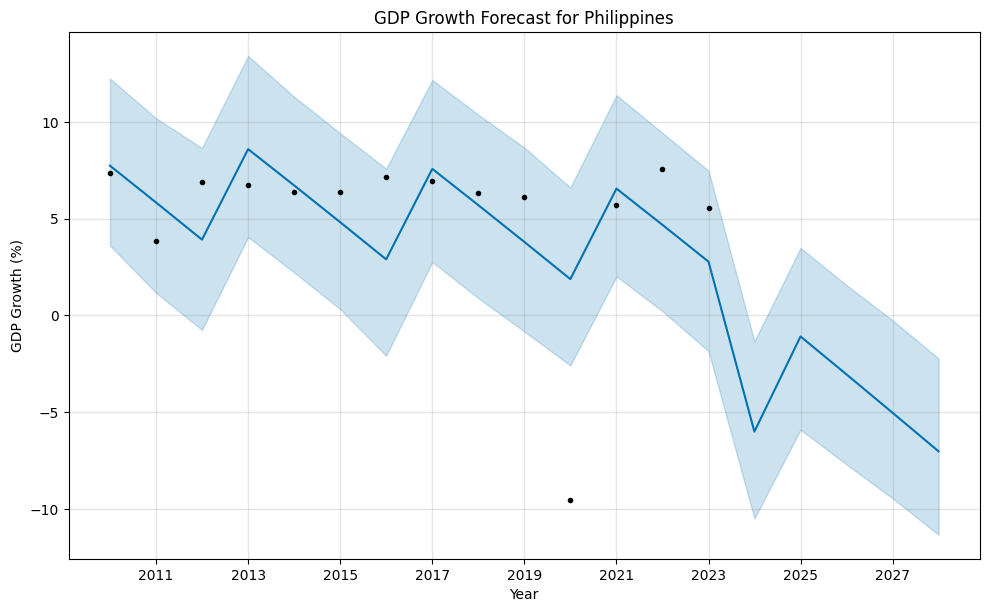

In [53]:
# Initialize model
model = Prophet()
model.fit(df_ts)

# Future years to predict
future = model.make_future_dataframe(periods=5, freq='Y')  # forecast 5 future years
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title(f"GDP Growth Forecast for {country}")
plt.xlabel("Year")
plt.ylabel("GDP Growth (%)")
plt.grid(True)
plt.show()

###### Black dots are actual gdp, blue line is forecasted, and shaded blue area is the confidence interval.

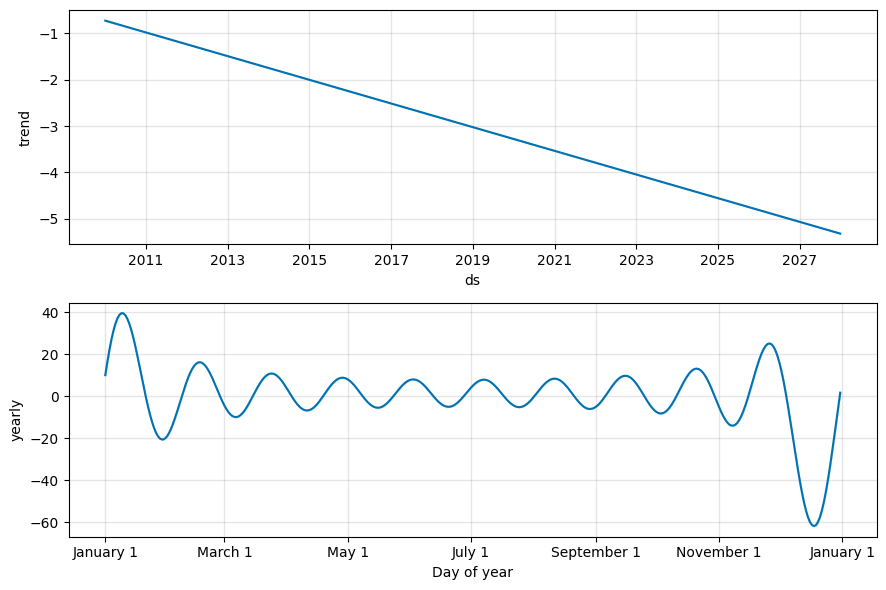

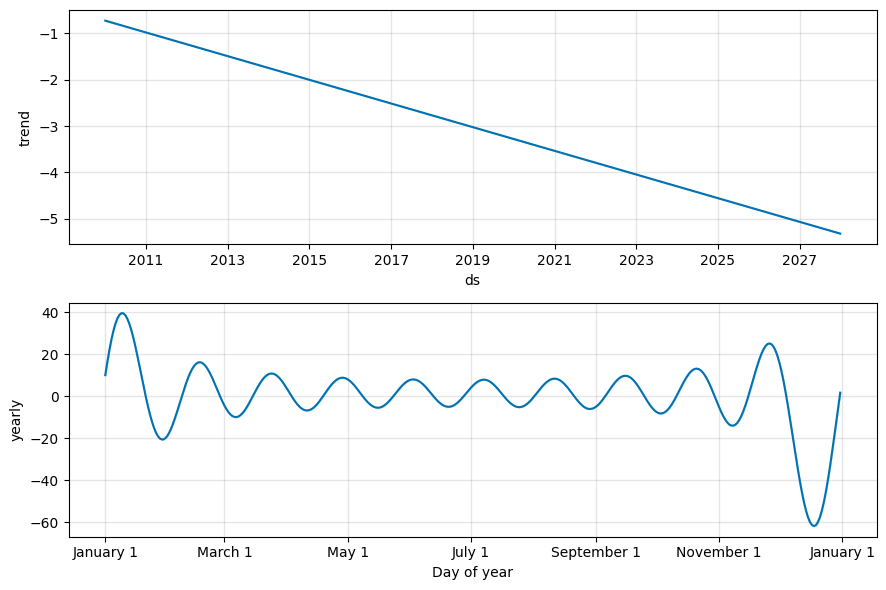

In [54]:
model.plot_components(forecast)

## Conclusions
#### Linear Regression Plot
- Most points tightly clustered between 0-5%, showing that many countries have a moderate growth
- Predictions are mostly compressed and are not very accurate in capturing growth
- The model is likely underfitting as the GDP growth is being predicted close to the mean
#### Feature Importance
- **Inflation (GDP Deflator)** is the strongest predictor
- **Unemployment rate, GDP per capita and current account balance** also contribute significantly 
- Macroeconomics are leading factors in classification decisions
    - *Overheating (economy expanding at an exponential rate)* and *fiscal imbalances (government spending doesn't match their revenue)* might help model
#### Two-Dimensional PCA Projection
- Reasonably separated in PCA, however the explained variance of the projection is below 50%
- Groups may represent:
    - Cluster 0: developing nations (low income, lower growth, low debt)
    - Cluster 1: Emerging economies (moderate inflation/growth, higher population)
    - Cluster 2: Advanced economies (High GDP per capita, stable indicators)
    - Cluster 3: Volatile/High debt/High inflation countries
#### Philippines Case Study, Forecast Plot
- Forecast plot suggests a gradual decline in GDP growth throughout 2025-2028, potentially even entering recession territory.
- Drop after 2023 is very sharp. Likely due to the aftermath of covid-19 being especially harsh in the Philippines.
- Components plot:
    - Top Plot: Trend Component:
        - consistently declining trend in growtch since 2015.
        - could be the long-term linear direction of the economy.
    - Bottom Plot: Seasonality Component:
        - yearly patterns in te data
        some cynical behavior but also a lot of noice.
            - common for seasonality to be weak in macoeconomic data